# Simulating an Interferometer

In this notebook, interferometers are introduced and described. Then, the [EVLA](https://science.nrao.edu/facilities/vla/docs/manuals/oss2016A/intro/overview) (in its D-configuration) is simulated. For this, the path of the incoming image is traced and then reconstructed. Click [here](https://gesis.mybinder.org/binder/v2/gh/SansithH/Interferometer_simulation/main) for the binder link.

## What is an interferometer?

All telescopes (optical or not) have an inherent limit to their resolution due to the effects of light diffracting around the telescopes aperture. This limit is known as the Rayleigh limit, which is defined as the point where two point sources can no longer be seen as two different sources. It is defined by $\theta = 1.22 \frac{\lambda}{D}$, where: $\theta$ is the angular distance (in radians); $\lambda$ is the wavelength of the light at which you are operating; and $D$ is the diameter of the telescope aperature. The number $1.22$ comes from the distance to the first minimum of an Airy disk (which is the diffraction pattern of a circular disk, the shape of the telescope aperture).

In [1]:
import interferometer
import numpy as np
from scipy import signal
import matplotlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams["figure.figsize"] = (20,20)

![Rayleigh Criterion](img/Rayleigh_criterion.png)
> The above image ([source](https://www.radio2space.com/introduction-to-radio-interferometry/)) visually shows the Rayleigh Criterion, which is used as the lower limit to angular distance after which the two sources can no longer be resolved separately. Note that each individual source is diffracted into an Airy Disk.

The problem with radio telescopes is that the radio waves have very large wavelengths, which means immense dishes are needed to get good resolution. For example, the Hubble Space Telescope has an aperture size of $2.4$m and observes visible light has wavelengths from $\approx 400 - 700$nm (let's take $600$m as an example)

In [2]:
wavelength_hst = 600*10**(-9)
aperture_size_hst = 2.4

Therefore, the angular resolution of the Hubble Telescope is:

In [3]:
angular_res = 1.22*wavelength_hst/aperture_size_hst
print('Angular Resolution of Hubble Space Telescope = {:.2e} radians'.format(angular_res))

Angular Resolution of Hubble Space Telescope = 3.05e-07 radians


For a radio telescope with similar angular resolution, that observes at $1$GHz (this has wavelength of $0.3$m):

In [4]:
wavelength_radio = 299792458 * 10 **(-9)
aperture_size_radio = 1.22*wavelength_radio/angular_res / 1000
print('Size of radio telescope = {:.0f} km'.format(aperture_size_radio))

Size of radio telescope = 1199 km


From this, you can see that a dish $1200$km is needed to get angular resolution as good as the HST. This is simply infeasible to build.

Because building the normal full dishes are impractical, interferometers are used. Interferometers, in the simplest terms, use many smaller telescopes dispersed over a large area to imitate a large dish. This way, high angular resolutions can be achieved without having to build the full dish. This means that the telescopes can be separated by very large distances (like across continents) to see very small angular resolutions for relatively little additional cost. 

However, the sensitivity of the telescope is proportional to the collecting area. Since interferometers have large sections of the "full dish" unmeasured, they suffer greatly in the sensitivity department and struggle to see dim sources. This means that long observing times are typically needed. In addition to this, interferometers require the pure measured waveforms from 30 or more telescopes which can mean data rates of several gigabytes per second. This means that data handing and processing can take significant amounts of time.

## How it works

If you consider the light from a source getting diffracted through a double slit, an inverse relationship can be noticed between the angular size of the source and the fringe visibility (i.e. the response function). There is, in fact, a fourier transform relationship between the shape of the source and the response function.
There is also a similar relationship between the shape and distance between the two slits. If the distance between the slits is large, the response function is sensitive to small scale structure in the source and vice versa.

The radio interferometer is an extension of this idea. Each pair of telescopes effectively form a double slit diffractor. Therefore, each pair of telescopes will give information on a fourier component of the source (specifically, each pair gives a spatial frequency and its orientation).

## The projected baseline

The [EVLA](https://science.nrao.edu/facilities/vla/docs/manuals/oss2016A/intro/overview) has many telescopes. The telescopes used in the D-configuration has the following shape. Note that the distance is measured in nanoseconds (i.e. time taken for light to travel the distance)

In [5]:
antennae_positions = interferometer.choose_ant(configuration="D")

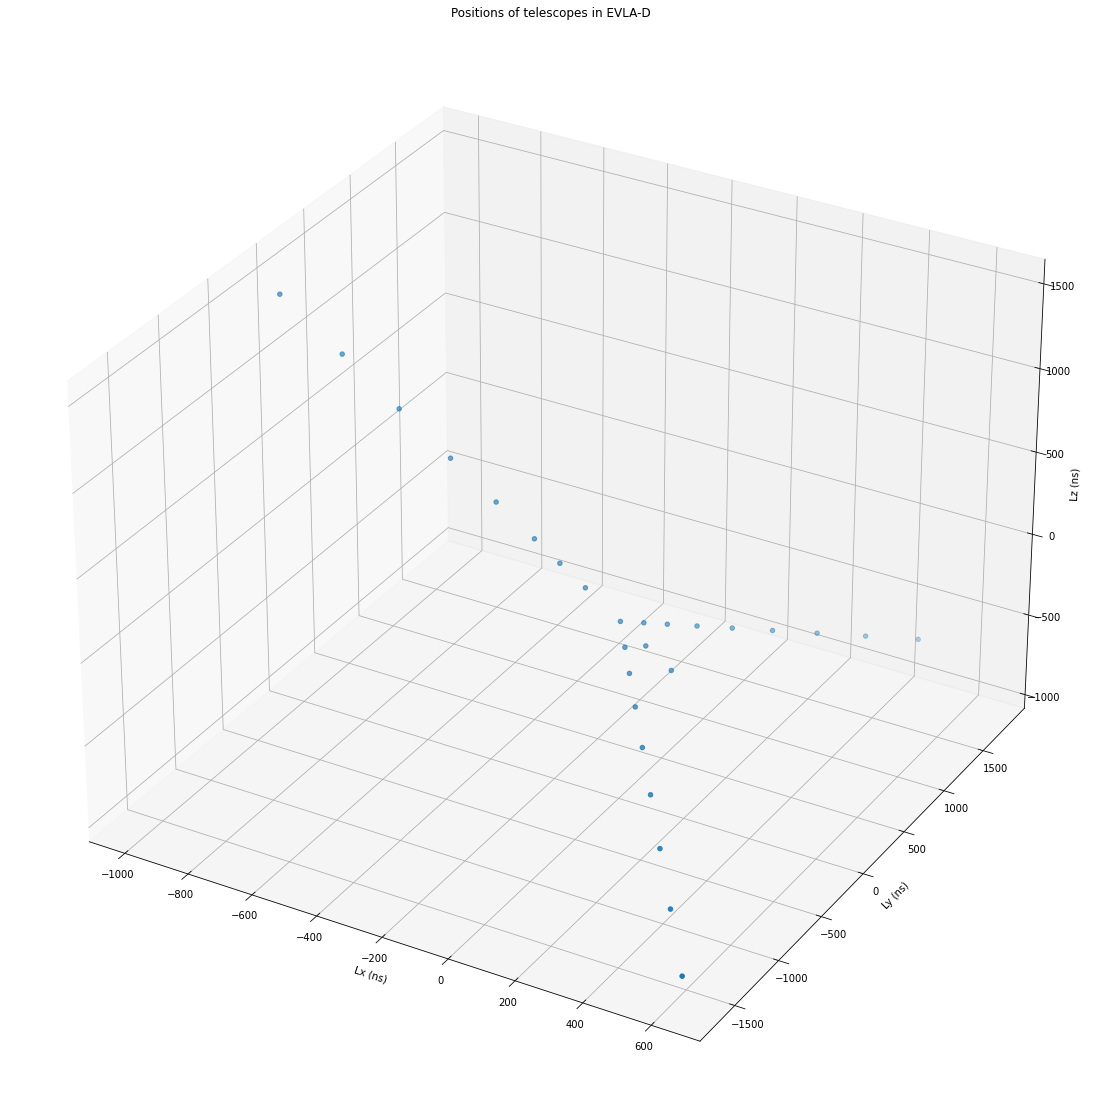

In [6]:
fig_xyz = plt.figure()
ax_xyz = fig_xyz.add_subplot(111, projection='3d')

ax_xyz.scatter(antennae_positions['Lx(ns)'], antennae_positions['Ly(ns)'], antennae_positions['Lz(ns)'])
ax_xyz.set_title('Positions of telescopes in EVLA-D')
ax_xyz.set_xlabel('Lx (ns)')
ax_xyz.set_ylabel('Ly (ns)')
ax_xyz.set_zlabel('Lz (ns)')
plt.show()

In this case the positions are in the XYZ coordinate. The Z-axis is alinged with Earth's rotation axis, the Y-axis points East and the X-axis is in such a direction as to get a right-handed coordinate system.

The most useful coordinate system is the UVW coordinate system. This is the view of the telescope system from the point of view of the target star. The W-axis points along the observing direction, the U-axis points along the meridian defined by the hour angle, and the V-axis finishes the right-handed coordinate system. The transformation from the XYZ coordinate frame to the UVW coordinate frame is the following rotation.

\begin{gather}
    \begin{bmatrix}
        U \\ V \\ W
    \end{bmatrix}
    =
    \begin{bmatrix}
        \sin H & \cos H & 0 \\
        - \sin \delta \cos H & \sin \delta \sin H  & \cos \delta \\
        \cos \delta \cos H & - \cos \delta \sin H & \sin \delta
    \end{bmatrix}
    \begin{bmatrix}
        X \\ Y \\ Z
    \end{bmatrix}
\end{gather}
    

where $H$ is the hour angle of the target and $\delta$ is the declination of the target. Hour angle and declination form a coordinate system that map the sky and are analogous to latittude and longitude.

The positions of the telescopes in UVW coordinates for observing a target at declination of $+45$ and an hour angle of $0.0$ are as follows. Note that distances have been converted to metres.

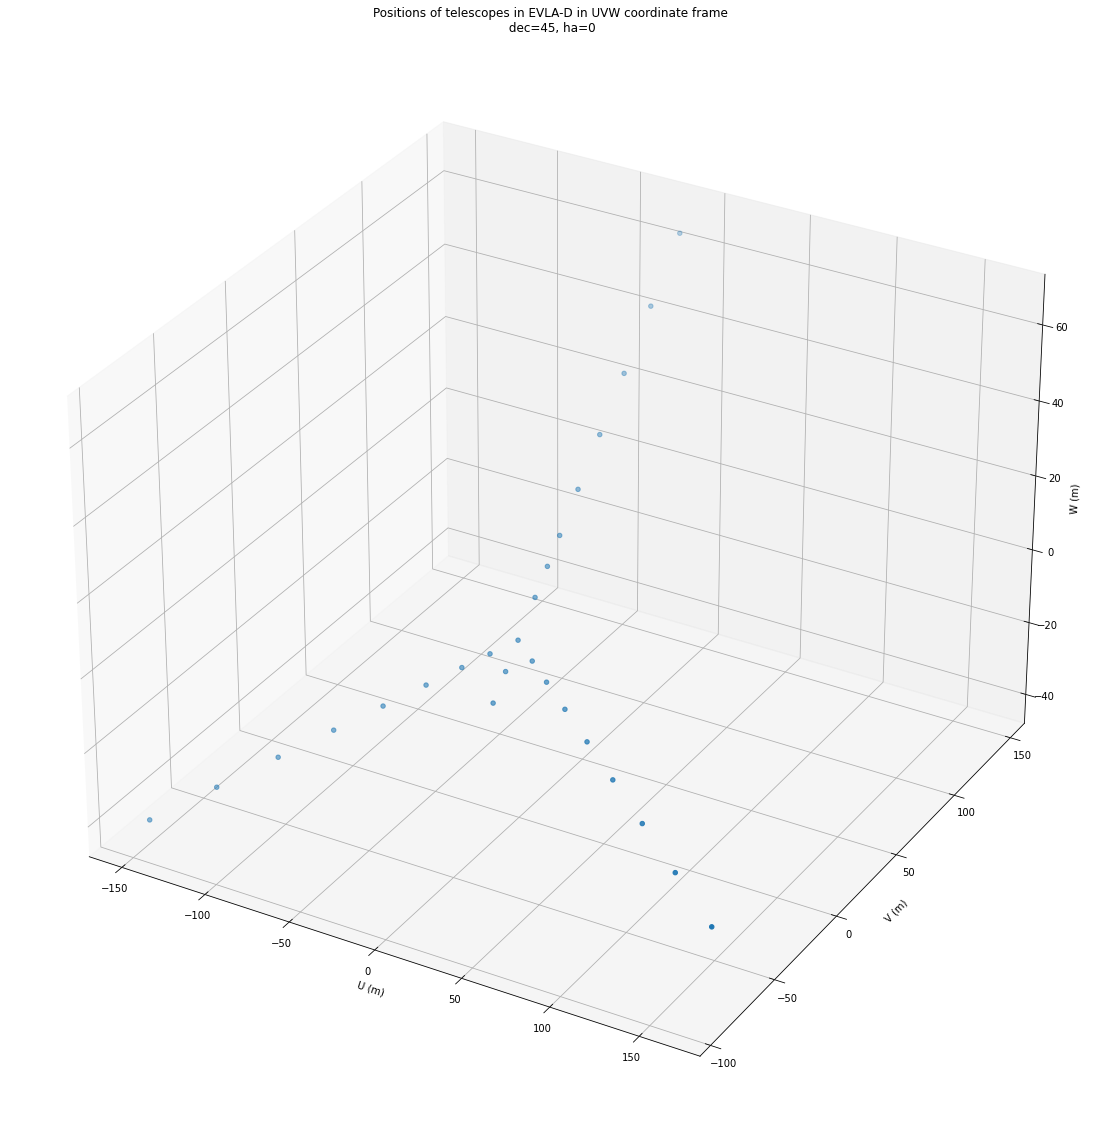

In [7]:
declination = 45
hour_angle = 0
UVW_matrix = interferometer.convert_XYZ_to_UVW(antennae_positions, declination, hour_angle)
fig_uvw = plt.figure()
ax_uvw = fig_uvw.add_subplot(111, projection="3d")
ax_uvw.scatter(UVW_matrix[0], UVW_matrix[1], UVW_matrix[2])
ax_uvw.set_title('Positions of telescopes in EVLA-D in UVW coordinate frame\n dec={}, ha={}'.format(declination, hour_angle))
ax_uvw.set_xlabel('U (m)')
ax_uvw.set_ylabel('V (m)')
ax_uvw.set_zlabel('W (m)')
plt.show()

The waveforms from each pair of telescopes are correlated and the geometric delay between each pair of telescopes is removed by adding appropriate delays (see image below). This way, the effects of the W coordinate is removed.

![2 element interferometer](img/2-element_interferometer.png)

> This image shows a diagram of a 2-element interferometer. $B$ is the baseline (distance between the two telescopes), $s$ is the vector pointing in the direction of the source. It can be seen that left-side telescope is delayed by a time of $\tau_g$ relative to the right-side telescope. This delay is added to right-side at $\tau_i$. Now that the waveforms from the two telescopes only have differences through differences in physical position, the two signals are combined in the correlator.
>> Figure from "Tools of Radio Astronomy" by TL Wilson, K Rohlfs and S Hüttemeister)

Each pair of telescopes will create one point in the aperture plane at the baseline vector (two if you also consider the negative vector).

The aperture plane for the EVLA is seen below. This is found by finding the vector difference between every pair of telescopes. (the negative vectors are also included therefore there are $N(N-1)$ baselines (where $N$ is the number of telescopes).

Text(0, 0.5, 'V (m)')

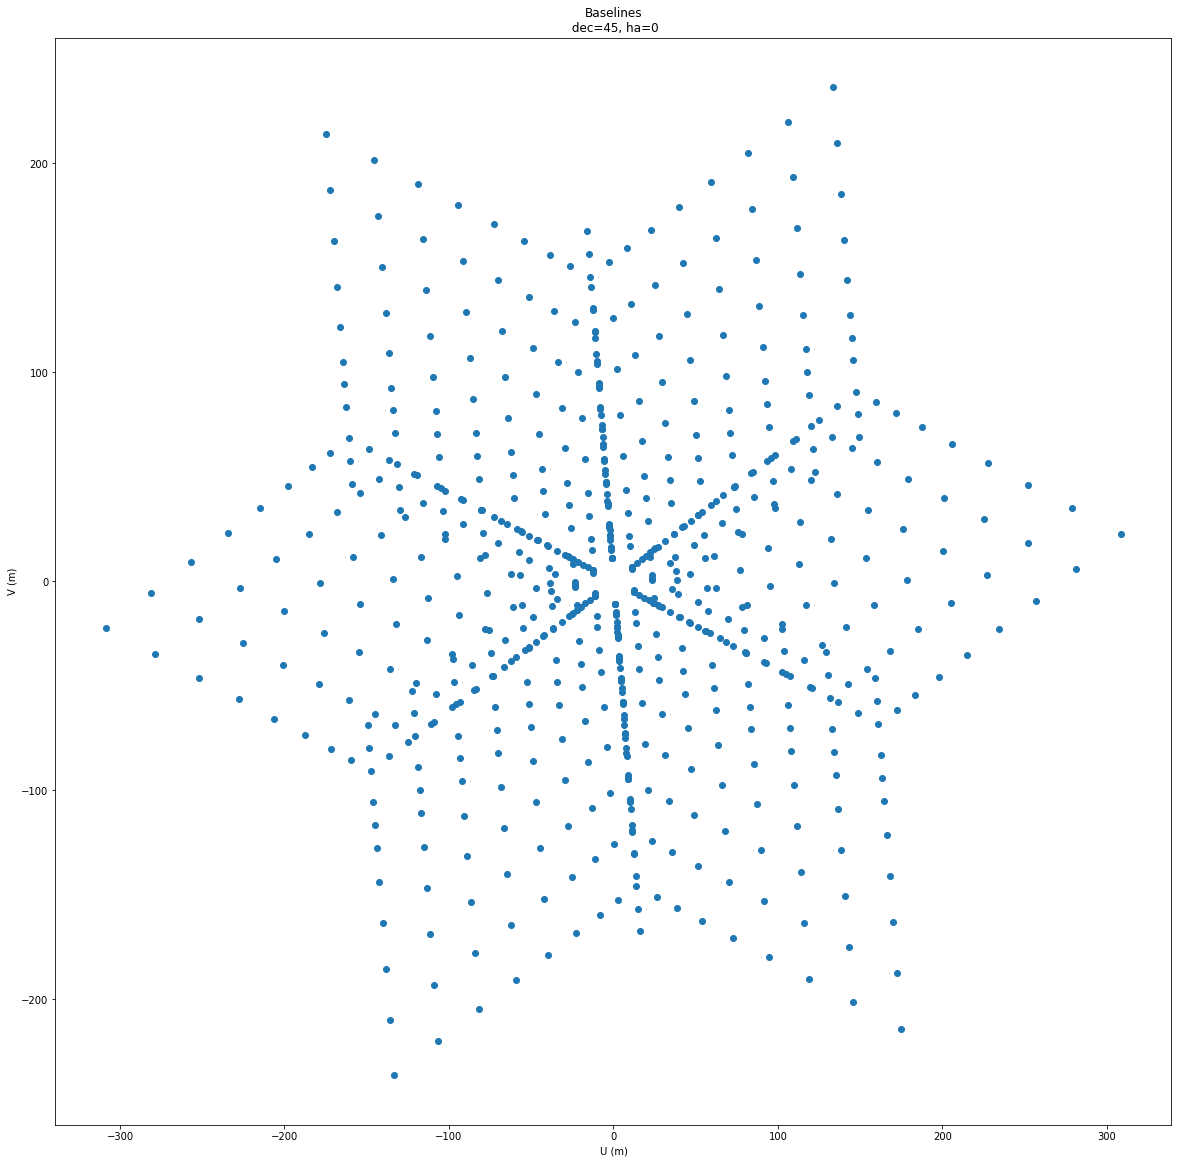

In [8]:
baselines = interferometer.make_baselines(declination, [hour_angle], antennae_positions)
fig_base =  plt.figure()
ax_base = fig_base.add_subplot(111)
ax_base.scatter(baselines[0], baselines[1])
ax_base.set_title('Baselines\n dec={}, ha={}'.format(declination, hour_angle))
ax_base.set_xlabel('U (m)')
ax_base.set_ylabel('V (m)')

The above baselines are generated by the UVW coordinates at an hour angle of 0. As the Earth rotates, the position of the target relative to the telescopes changes. This means the hour angle chages. This results in the baselines tracing out ellipses in the UV-plane over time. 
The following baselines are calculated by observing from $H=-0.5$ to $H=+0.5$ observing every 30 seconds.

In [9]:
hour_angle_set = np.arange(-0.5, 0.5, 30/3600)

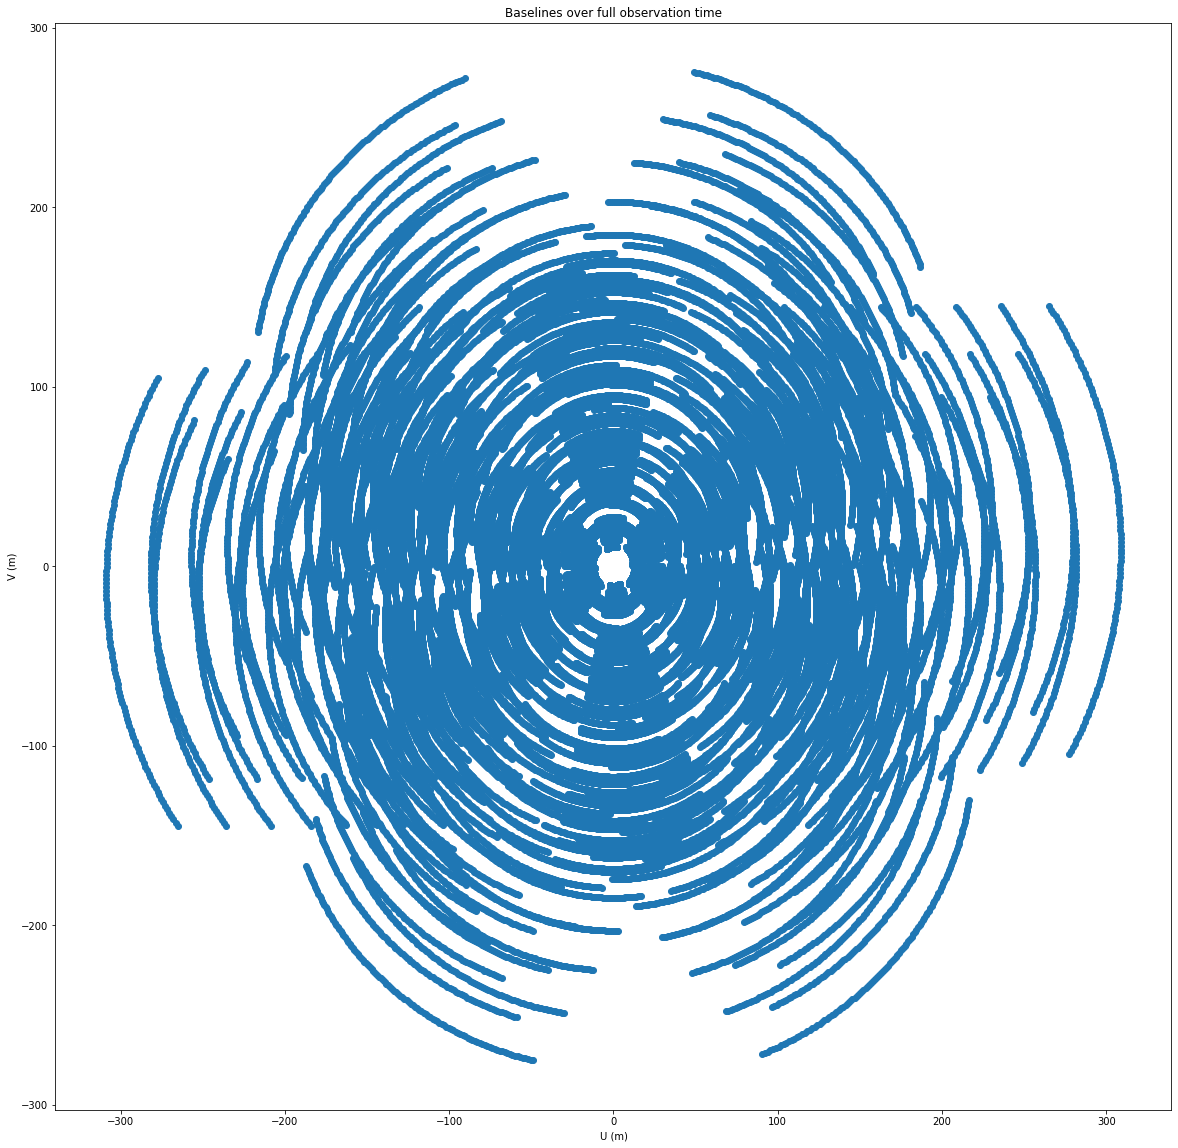

In [10]:
full_baselines = interferometer.make_baselines(declination, hour_angle_set, antennae_positions)
fig_full_base =  plt.figure()
ax_full_base = fig_full_base.add_subplot(111)
ax_full_base.scatter(full_baselines[0], full_baselines[1])
ax_full_base.set_title('Baselines over full observation time')
ax_full_base.set_xlabel('U (m)')
ax_full_base.set_ylabel('V (m)')
plt.show()

## Sampling function

As can be seen, a large part of the space is covered. This can be better seen as a sampling function, $S(u,v)$, which is defined as $S=1$ where a baseline vector exists and $S=0$ elsewhere. In this case the sampling function is set to the nearest meter.

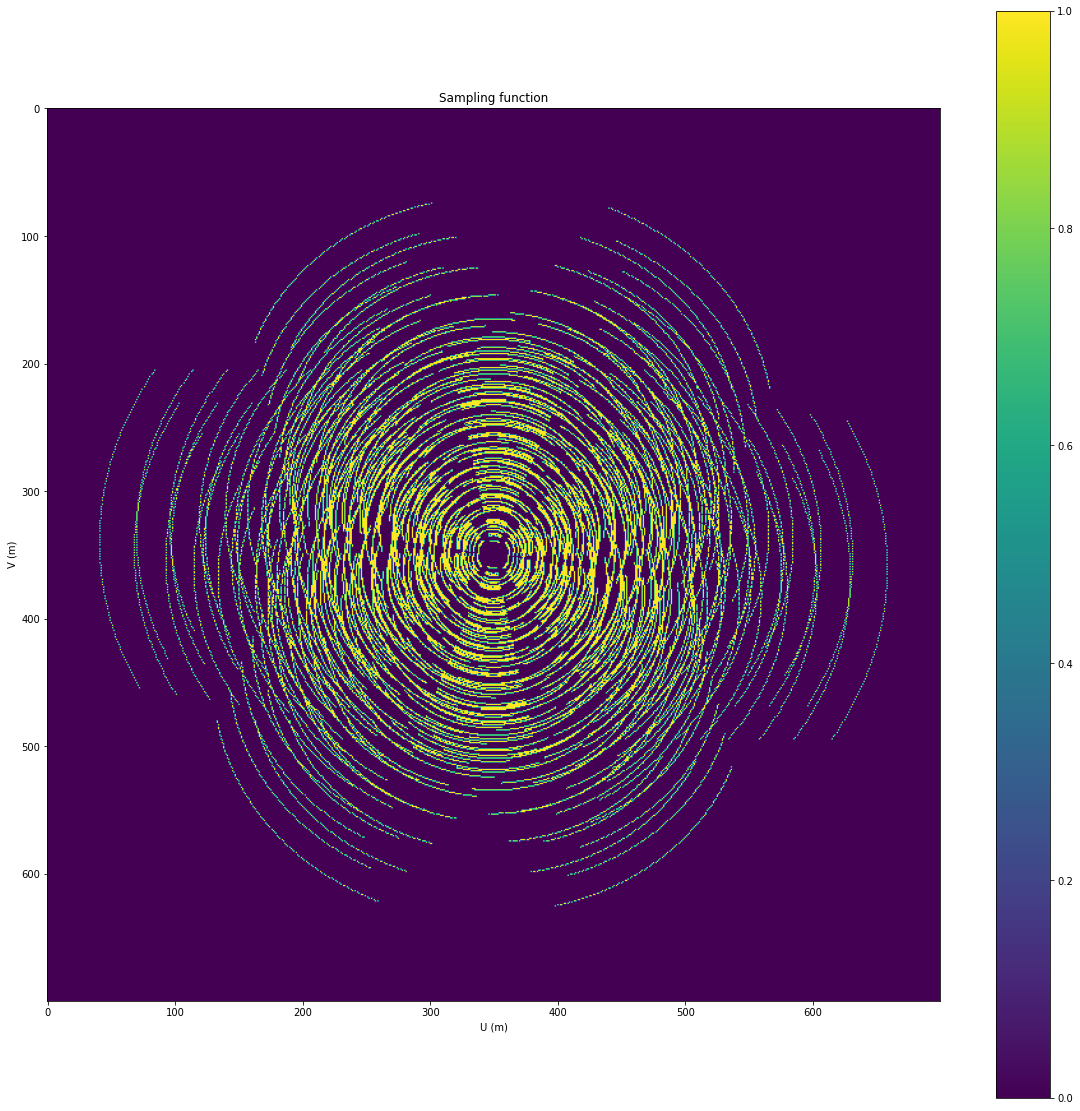

In [11]:
sampling_function, samp_res = interferometer.make_sampling_func(full_baselines, res = 1)
plt.imshow(sampling_function)
plt.title('Sampling function')
plt.xlabel("U (m)")
plt.ylabel("V (m)")
plt.colorbar()
plt.show()

Each of these baselines contribute some information on the spatial distribution of the target. The small baselines (from telescopes near each other) are sensitive to large scale variation, while large baselines are sensitive to small angular resolutions but insensitive to small scale structures. From this, it can be seen that full coverage of the aperture plane will provide enough information to recondtruct a full image of the target. However, by neccessity, there are gaps in the sampling function (because we are using many separate telescopes). This results in the reconstructed image being convoluted by a point spread function. This point spread function is the 2D Fourier Transform of the sampling function. 

In [12]:
dirty_beam, dirty_beam_res = interferometer.fft_with_scaling(sampling_function, samp_res)

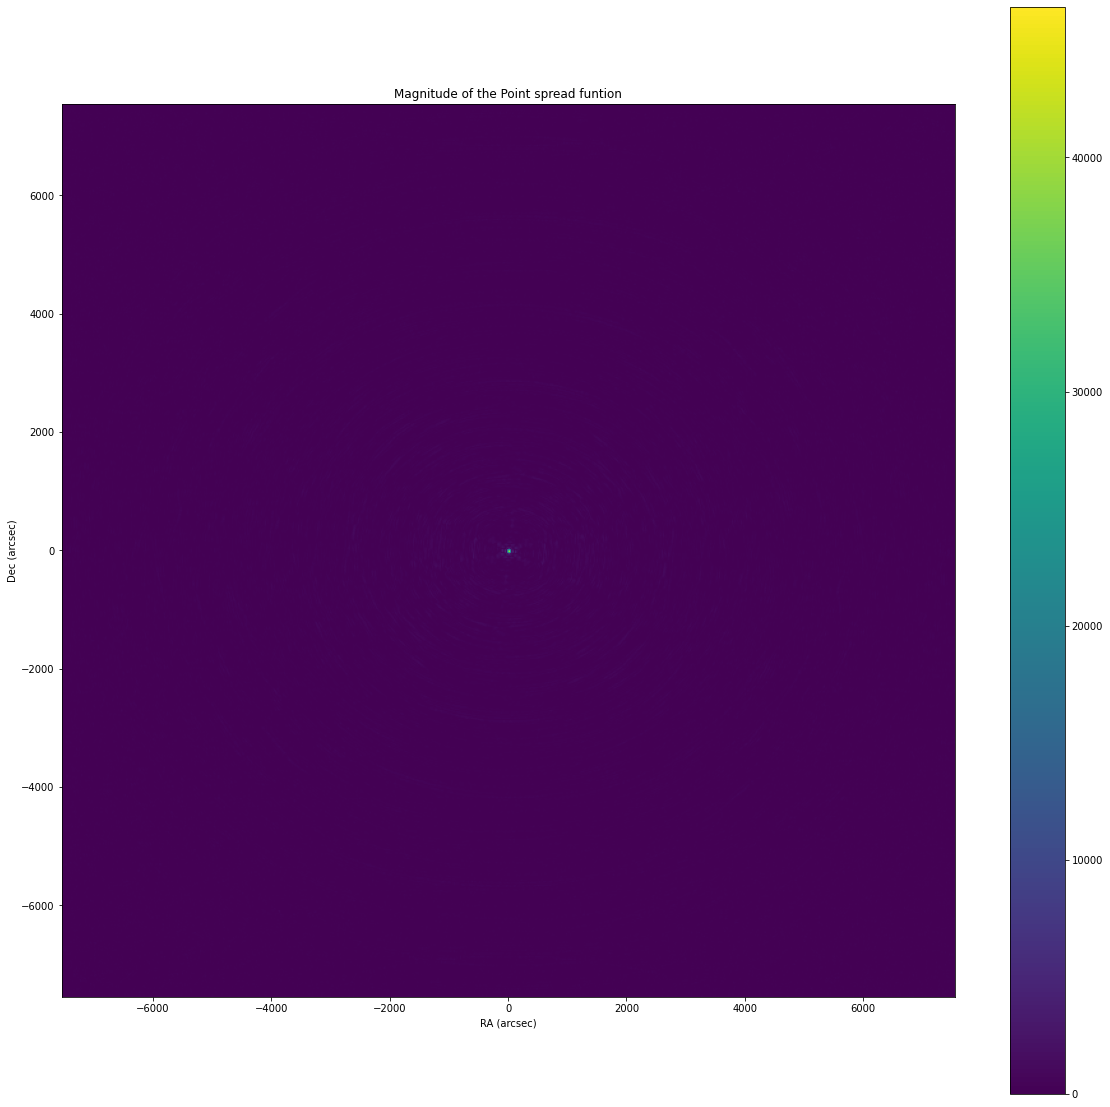

In [13]:
extent_x = len(dirty_beam[0])/2 * dirty_beam_res
extent_y = len(dirty_beam)/2 * dirty_beam_res

plt.imshow(np.abs(dirty_beam), extent=[-extent_x, +extent_x, -extent_y, +extent_y])
plt.title('Magnitude of the Point spread funtion')
plt.xlabel('RA (arcsec)')
plt.ylabel('Dec (arcsec)')
plt.colorbar()
plt.show()

Below is the centre of the above plot so it is seen clearer

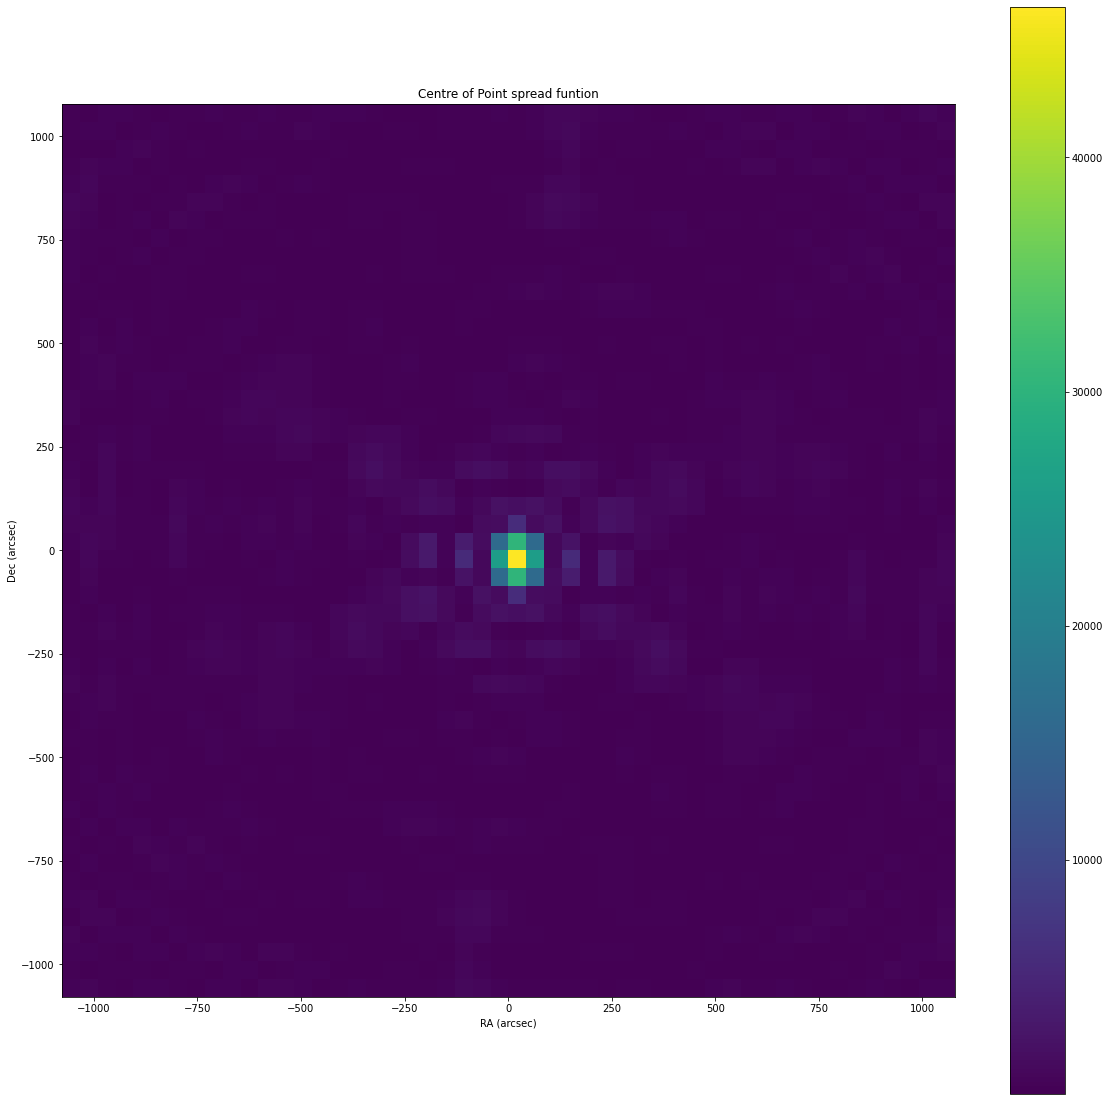

In [14]:
img_width = 50
# dirty_beam = np.fft.fftshift(np.fft.fft2(sampling_function))
y_lim = [(len(dirty_beam)-img_width)//2, (len(dirty_beam)+img_width)//2]
x_lim = [(len(dirty_beam[0])-img_width)//2, (len(dirty_beam[0])+img_width)//2]
dirty_beam_centre = dirty_beam[y_lim[0]:y_lim[1], x_lim[0]:x_lim[1]]
extent_centre = np.array([-img_width, +img_width, -img_width, +img_width]) * dirty_beam_res

plt.imshow(np.abs(dirty_beam_centre), extent=extent_centre)
plt.title('Centre of Point spread funtion')
plt.xlabel('RA (arcsec)')
plt.ylabel('Dec (arcsec)')
plt.colorbar()
plt.show()


The below plots show the same dirty beam it instead show the phase.

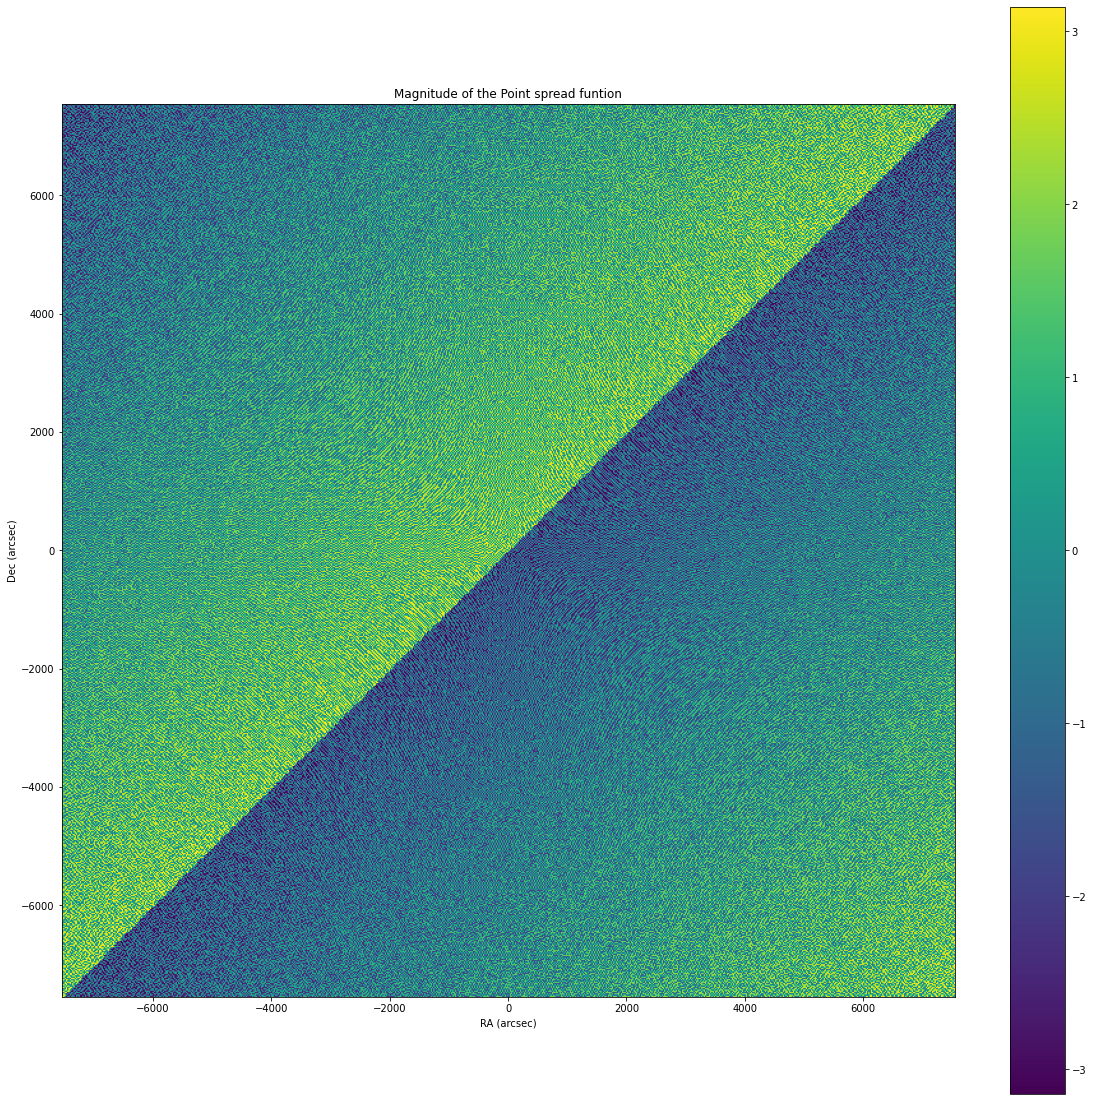

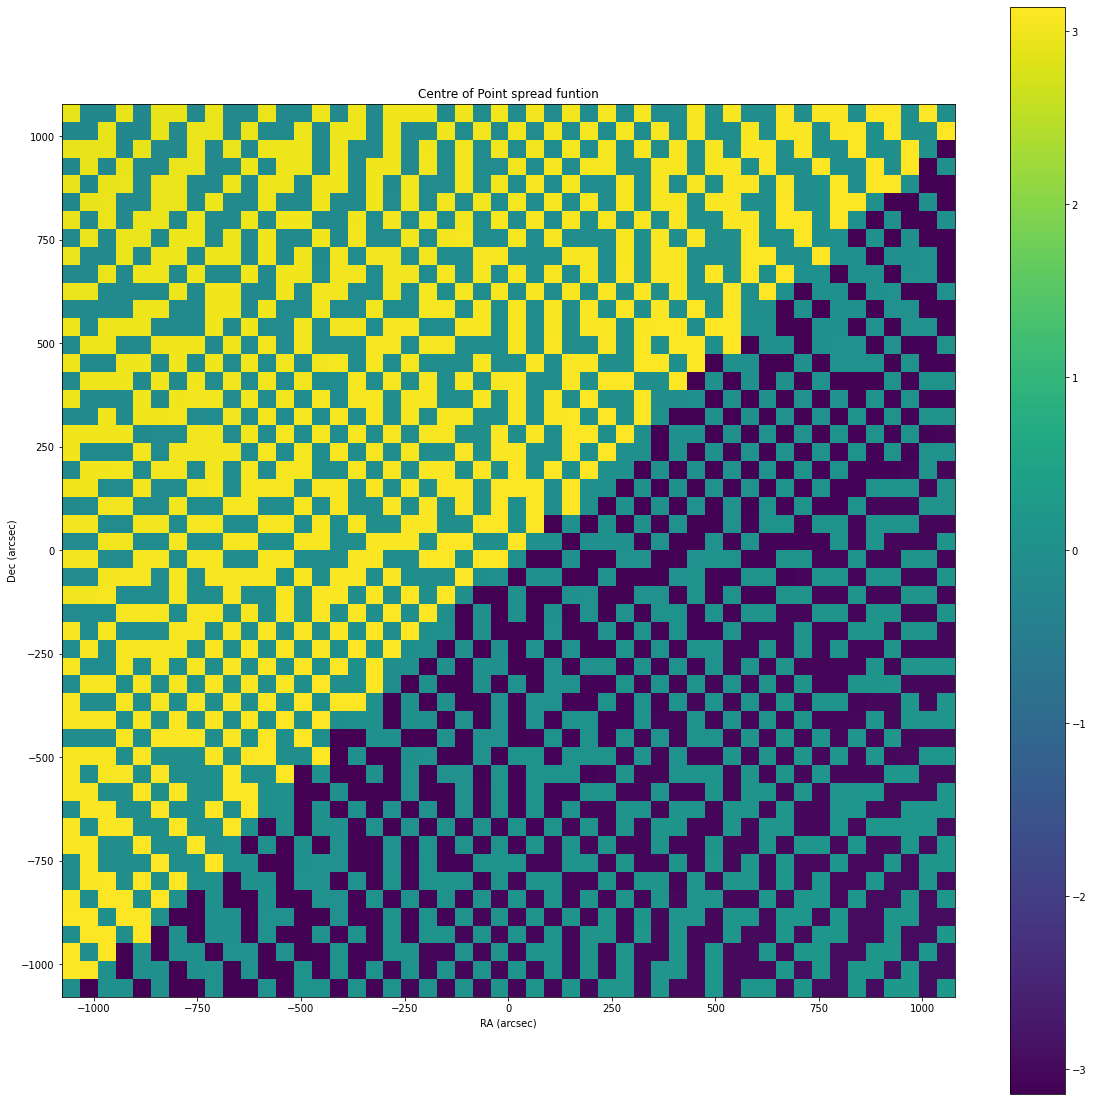

In [15]:
plt.imshow(np.angle(dirty_beam), extent=[-extent_x, +extent_x, -extent_y, +extent_y])
plt.title('Magnitude of the Point spread funtion')
plt.xlabel('RA (arcsec)')
plt.ylabel('Dec (arcsec)')
plt.colorbar()
plt.show()

plt.imshow(np.angle(dirty_beam_centre), extent=extent_centre)
plt.title('Centre of Point spread funtion')
plt.xlabel('RA (arcsec)')
plt.ylabel('Dec (arcsec)')
plt.colorbar()
plt.show()

Since the largest baseline determines the smallest possible resolution,the largest and smallest angular resolutions the interferometer is sensitive to, when observing at 5GHz, are:

In [16]:
baseline_lengths = np.sqrt(np.square(full_baselines[0,:]) + np.square(full_baselines[1,:]))
max_baseline = max(baseline_lengths)
min_baseline = min(baseline_lengths)
print('max_baseline = ', max_baseline, '\nmin_baseline =', min_baseline)

max_baseline =  309.3589972209598 
min_baseline = 10.619277164750965


In [17]:
observing_wavelength = (299792458)/(5*10**9)    # lambda = c/f
min_resolution = interferometer.diameter_to_ang_res(max_baseline, observing_wavelength)
max_resolution = interferometer.diameter_to_ang_res(min_baseline, observing_wavelength)
print('min_resolution (arcsec) = ', min_resolution, '\nmax_resolution (arcsec) =', max_resolution)

min_resolution (arcsec) =  48.772263460528094 
max_resolution (arcsec) = 1420.8253803213793


## Field of view

The field of view of the interferometer is the same as the field of view of the individual telescopes. The EVLA uses antennae 25m in [size](https://science.nrao.edu/facilities/vla/docs/manuals/oss2016A/ant_positions.pdf). Therefore the field of view of the interferometer is (arc seconds):

In [18]:
field_of_view = interferometer.diameter_to_ang_res(25, observing_wavelength)
print('Field of view of EVLA = {:.1f} arcsec'.format(field_of_view))

Field of view of EVLA = 603.5 arcsec


## Image

For this example, the target is two stars with positions and fluxes below:

    Source 1:
        Position: J 05 00 00 +45 00 00
        Flux density: 3.6 Jy
    Source 2:
        Position J 05 00 10 +45 03 00
        Flux density: 5.8 Jy

The target image can be seen below:

In [19]:
import image_generator
star_coords = [[0, 0], [10, 3 * 60]]
star_fluxes = [3.6, 5.8]

extent = [-field_of_view, field_of_view, -field_of_view, field_of_view] # in arcseconds

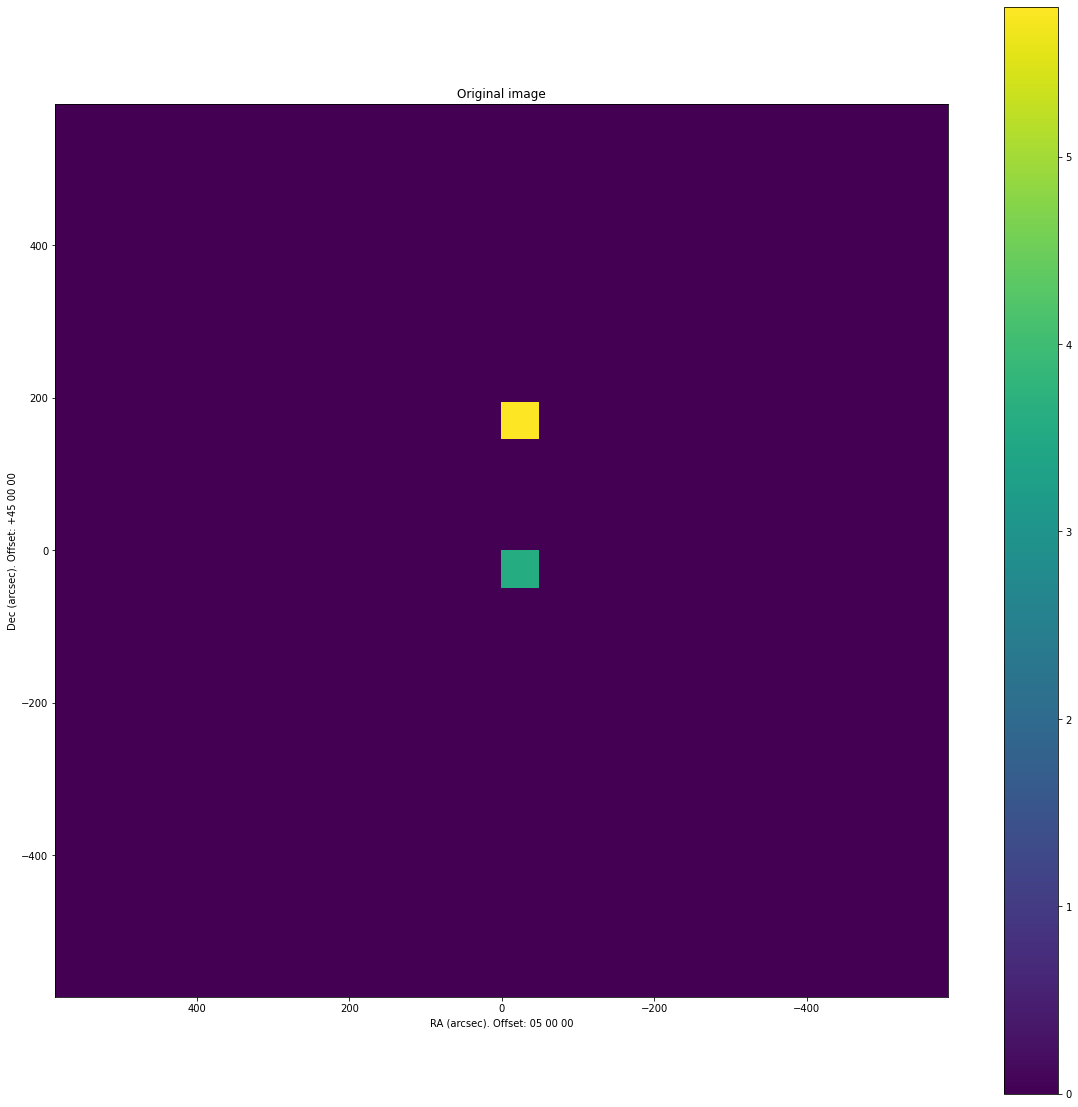

In [20]:
image, resolution = image_generator.delta_func_img(star_coords, star_fluxes, extent, min_resolution)
extent_x = len(image[0])/2 * resolution
extent_y = len(image)/2 * resolution
plt.imshow(image, extent=[+extent_x, -extent_x, -extent_y, +extent_y])
plt.title('Original image')
plt.colorbar()
plt.xlabel('RA (arcsec). Offset: 05 00 00')
plt.ylabel('Dec (arcsec). Offset: +45 00 00')
plt.show()

For this image, the resolution was chosen so as to match the smallest angular resolution visible to the interferometer

The visibilities observed by the interferometer is described by the following equivalent equations:
\begin{align}
    &\text{Sampling Function} &\times &\text{Fourier Transform of source} &= &\text{Measured Visibilities} \\
    &S(u,v) &\times &V_{\text{source}}(u,v) &= &V_{\text{measured}}(u, v)\\
    &\mathscr{F}[S(u,v)] &\ast &\mathscr{F}[V_{\text{source}}(u,v)] &= &\mathscr{F}[V_{\text{measured}}(u, v)]\\
    &S(\theta, \phi) &\ast &T(\theta, \phi) &= &T_D(\theta, \phi)\\
    &\text{Dirty beam} &\ast &\text{Image} &= &\text{Dirty image}
\end{align}

Therefore, the observed image (called "Dirty Image, $T_D(\theta, \phi)$" in the above equations) is:

In [21]:
observed_image = signal.convolve(dirty_beam, image)

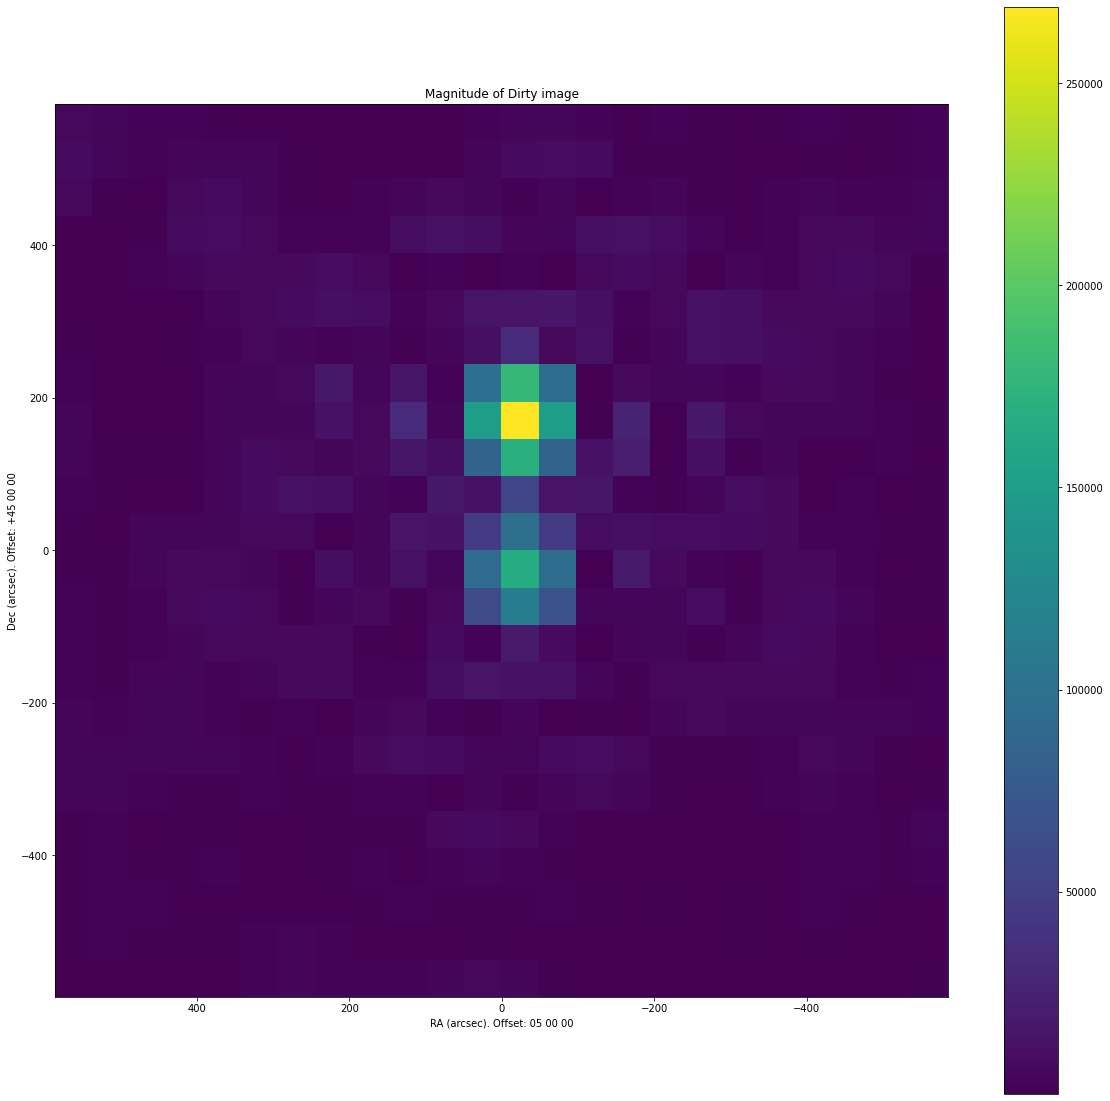

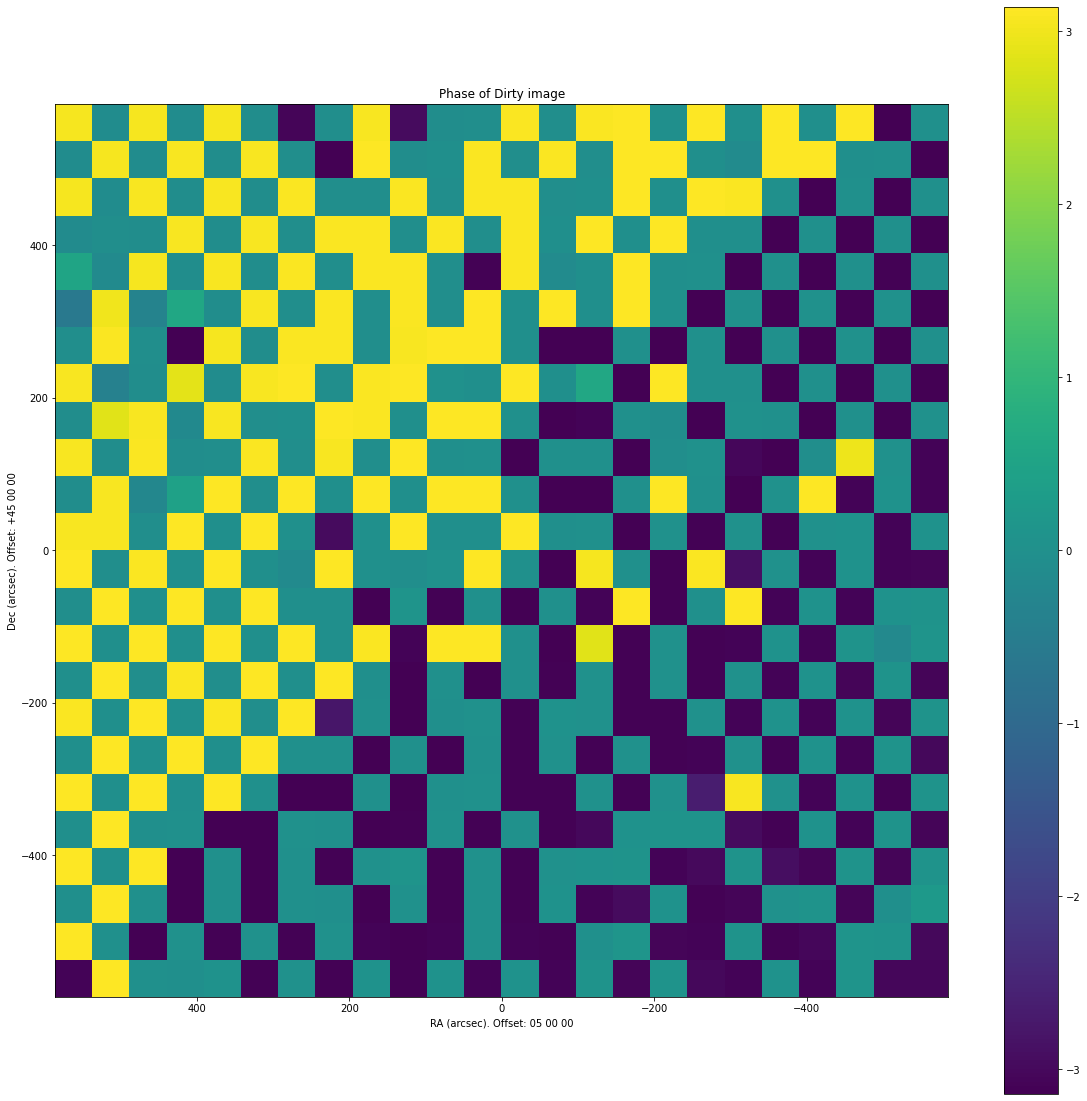

In [22]:
width_x = len(observed_image[0])/2 * resolution
width_y = len(observed_image)/2 * resolution
new_extent_x = len(observed_image[0])/2 * extent_x / width_x
new_extent_y = len(observed_image)/2 * extent_y / width_y
seen_image = observed_image[int(len(observed_image)/2-new_extent_y)+1 : 
                            int(len(observed_image)/2+new_extent_y)+1,
                           int(len(observed_image[0])/2-new_extent_x)+1 :
                            int(len(observed_image[0])/2+new_extent_x)+1]
plt.imshow(np.abs(seen_image), extent=[+extent_x, -extent_x, -extent_y, +extent_y])
plt.title('Magnitude of Dirty image')
plt.xlabel('RA (arcsec). Offset: 05 00 00')
plt.ylabel('Dec (arcsec). Offset: +45 00 00')
plt.colorbar()
plt.show()

plt.imshow(np.angle(seen_image), extent=[+extent_x, -extent_x, -extent_y, +extent_y])
plt.title('Phase of Dirty image')
plt.xlabel('RA (arcsec). Offset: 05 00 00')
plt.ylabel('Dec (arcsec). Offset: +45 00 00')
plt.colorbar()
plt.show()

From this, two sources can be distiguished. One at $\text{RA} = 05 00 20 \pm 60$  and $\text{dec} = +45 00 00 \pm 60$ the other at $\text{RA} = 05 00 60 \pm 20, \text{dec} = +45 02 50 \pm 60$

## Additional steps

Beyond the scope of this assignment are further methods to improve the picture that comes out.
One of these methods is deconvoluting the point spread function from the dirty image. This can be done using the Högbom CLEAN algorithm, which works by successively removing the point spread function from the dirty image. This will result in a picture that is sharper than would be expected from the baselines. This is because the deconvoluting algorithm assumes information (specifically, the Högbom CLEAN algorithm assumes the source is made of delta functions). This can be mitigated by blurring the image through a Maximum Entropy Method (MEM). This is equivalent to rounding a number to a appropriate number of significant figures. 

There is also the confounding effect of the atmosphere, which introduces random phase and amplitude noise in the data. This data varies for each telescope and chages with time. This is mitigated by periodically observing a bright object of known amplitude in a similar patch of sky. This is done by spending sometime observing the calibrator, switching to the target, then switching back to the calibrator and repeating this process for the duration of the observation period. While observing the calibrator, the affects of the atmosphere are corrected. These corrections are then interpolated to estimate the correction for the data (data observations are sandwiched between calibrator observations). 